# Predicting electricity Demand with weather data as an exogenous factor

Our Seasonal Arima model managed to make predictions that were decent, and for which the errors did not have any significant autocorrelation; however, an examination of the biggest remaining errors seemed to prove that the biggest errors occured during times of weather anomalies.  

**This notebook is an attempt to account for that by integrating weather data into the model.**

This is more for exploratory purposes than for prediction purposes, because in practice, we cannot predict weather anomalies several years in advance; however, assuming that monthly trends could be known in advance and that it would be useful to do so for example for the nuclear industry which needs more time to adjust its output than others and sometimes needs to schedule maintenance, improving predictions with weather modeling could be useful.

As we will see later in this notebook, integrating weather data leads to a significant reduction in the Root Mean Squared Error of the model, especially when using this data in XGBoost.

*Note that in this notebook, we only try to produce monthly predictions because we only have monthly weather data*

## Importing Libraries and Helper Functions

In [1]:
# standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
%matplotlib inline

#ignore warning messages
import warnings
warnings.filterwarnings('ignore')

# patsy: builds decision matrices for linear models with R style code
import patsy

#metrics for model evaluation
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

#linear regression: the statsmodels version is better than the sci-kit learn version in terms of summary statistics
from statsmodels.regression.linear_model import OLS
#Augmented Dickey Fuller test and ARIMA type models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import xgboost as xgb

#custom helper functions for this project: see Time_series_helpers.py for more information
from Time_series_helpers import rmse, mape, print_metrics, show_acf_plots, param_tracker, plot_feature_importances

## Loading weather data

<AxesSubplot:xlabel='Date_index'>

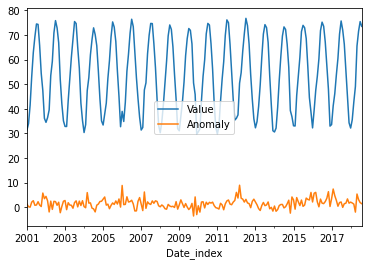

In [2]:
# Source of data: https://www.ncdc.noaa.gov/cag/national/time-series/110/tavg/all/8/2001-2018?
#base_prd=true&begbaseyear=1901&endbaseyear=2000&trend=true&trend_base=10&begtrendyear=1895&endtrendyear=2020

file_name = 'data/raw/110-tavg-all-8-2001-2018.csv'
weather = pd.read_csv(file_name, skiprows=4)

weather['Date_index'] = pd.to_datetime(weather['Date'], format='%Y%m')

weather.set_index('Date_index', inplace = True)

weather.drop('Date', axis='columns', inplace = True)

weather.plot()

In [3]:
#resetting the weather index so that it will exactly match that of the electricity data, which helps for merging
weather.index = weather.index.to_period(freq ='M')

As we can see in the plot above, we have information about the temperatures, and information about the temperature anomaly. However, the temperature anomaly is not necessarily so interesting from our perspective: electricity consumption depends on how extreme the temperatures are. A large positive anomaly in winter would be expected to result in less energy consumption, whereas a large positive anomaly in summer would result in more.  


## Loading Electricity data for the same period and merging

In [4]:
elec = pd.read_csv('data/processed/elec_clean.csv', index_col=[0], parse_dates=True)

monthly_elec = elec.resample('M', kind='period', label = 'left').sum()


<AxesSubplot:xlabel='Datetime'>

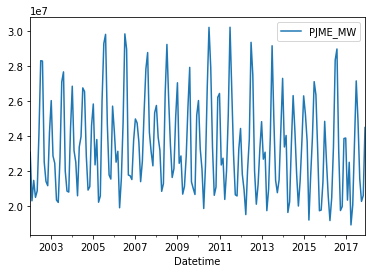

In [5]:
monthly_elec = monthly_elec[monthly_elec.index<'2018']
monthly_elec.plot()

### Making sure that the indexes are the same so that both tables can be merged properly

In [6]:
monthly_elec.index

PeriodIndex(['2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06',
             '2002-07', '2002-08', '2002-09', '2002-10',
             ...
             '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
             '2017-09', '2017-10', '2017-11', '2017-12'],
            dtype='period[M]', name='Datetime', length=192, freq='M')

<AxesSubplot:>

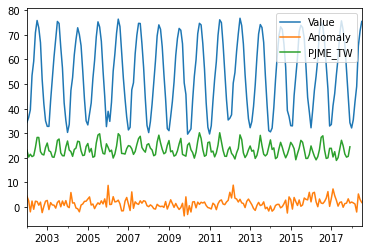

In [7]:
weather = weather[weather.index >= "2002"]

weather_elec = pd.concat([weather, monthly_elec], axis=1)

weather_elec = weather_elec.iloc[:-1,]


#putting PJME_MW on a similar scale as temperatures for better plotting
weather_elec['PJME_TW'] = weather_elec['PJME_MW']/1e6

weather_elec.drop('PJME_MW', axis = 'columns', inplace=True)

weather_elec.plot()

### Setting a value for the temperature that leads to low electricity consumption

As we can see in the plot above, there is definitely a connection between the cycle of temperatures and the cycle of electricity consumption: electricity consumption peaks when temperatures are at high points or at low points. 

We need to find the right transform for temperature so that the relationship between the 2 becomes linear.

In [8]:
weather_elec['PJME_TW'].quantile(.2) 

20.8957552

The 20th percentile of electricity consumption is 20.9 TW a month; we'll look at mean temperatures for any time that the electricity consumption is under 21 to determine a value that corresponds to low consumption.

In [9]:
weather_elec[weather_elec.PJME_TW < 21].Value.sample(10)

2017-04    53.80
2016-11    47.97
2016-04    53.19
2004-10    55.36
2004-04    52.68
2005-05    59.56
2008-04    50.40
2003-10    56.55
2015-04    53.24
2017-02    41.18
Freq: M, Name: Value, dtype: float64

Temperature values from the 40s to upper 50s are associated with the lowest electricity consumption.

In [10]:
weather_elec[weather_elec.PJME_TW >26].Value.sample(10)

2003-01    32.81
2010-08    74.05
2009-08    71.89
2005-08    73.20
2007-08    74.64
2017-07    75.70
2004-08    70.16
2014-01    30.56
2003-08    74.66
2004-01    30.34
Freq: M, Name: Value, dtype: float64

In contrast, when the monthly electricity consumption is over 26, temperature values seem to be either 70 and above or 33 and below. 

Therefore, it makes sense to use the value of 52 as our basis for transformation. We square the difference of the actual temperature value with 52 to see if we can observe a linear relationship with electricity consumption.

In [11]:
weather_elec['Temp_extreme_index'] = weather_elec['Value'].apply(lambda t: (t-52)**2)

### Linear model: energy consumption vs temperature
Below, we fit a linear model to the relationship between energy consumption and the temperature extreme index we have just built, to see how the two correlate.

In [12]:
outcome, predictors = patsy.dmatrices('PJME_TW ~ Temp_extreme_index', weather_elec)

lr_model = OLS(outcome, predictors)
lr_model_fit = lr_model.fit()
lr_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PJME_TW   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     732.1
Date:                Fri, 25 Sep 2020   Prob (F-statistic):           4.37e-67
Time:                        10:57:26   Log-Likelihood:                -310.65
No. Observations:                 192   AIC:                             625.3
Df Residuals:                     190   BIC:                             631.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             20.3814      0.144    142.014      0.000      20.098      20.664
Temp_extreme_index     0.0134      0.000     27.057      0.000       0.012       0.014
==============================================================================
Omnibus:                        1.879   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.917
Skew:                           0.234   Prob(JB):                        0.384
Kurtosis:                       2.856   Cond. No.                         469.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Plot of the relationship

<Figure size 720x576 with 0 Axes>

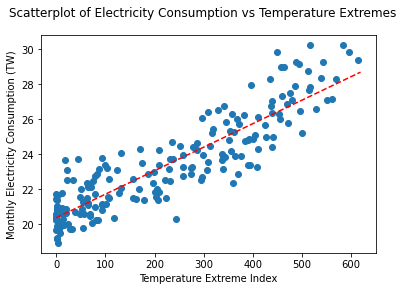

In [13]:
fig = plt.figure(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(weather_elec['Temp_extreme_index'], weather_elec['PJME_TW'])
x = np.arange(620)
y = 0.0134 * x + 20.3814
ax.plot(x,y, color = 'r', ls = '--')
plt.xlabel('Temperature Extreme Index')
plt.ylabel('Monthly Electricity Consumption (TW)')
fig.suptitle('Scatterplot of Electricity Consumption vs Temperature Extremes')
fig.show()
fig.savefig('temperatures_elec_consumption_scatterplot2.png')

There seems to be quite a clear relationship, and the R-squared statistic tells us that almost 80% of the variance in energy consumption can be explained by the temperature extreme index. 


Now that we have a variable for temperature that seems like a good predictor for electricity consumption; it's time to look at 
how well this variable does for forecasting. If we don't know the electricity consumption in advance, but have a good estimate of the temperature, what gain in accuracy can we achieve?

### Splitting the data into training and validation set

In [14]:
we_data = weather_elec.copy()
train, test = we_data[we_data.index < '2016'], we_data[(we_data.index >= '2016') & (we_data.index < '2018')]

# calculating monthly means for temperatures and electricity consumption
train['Month'] = train.index.month
month_means = train.groupby('Month').mean()

month_means

,Value,Anomaly,PJME_TW,Temp_extreme_index
Month,,,,
1,32.500714,2.380714,25.656359,386.480493
2,34.402857,0.582857,22.945488,313.601157
3,43.673571,2.173571,22.845241,77.924321
4,52.281429,1.231429,20.219434,2.499343
5,60.913571,0.713571,21.507348,81.104193
6,69.796429,1.306429,24.555775,317.703221
7,74.742143,1.132143,28.309937,518.797293
8,73.152143,1.052143,27.259943,448.946321
9,66.196429,1.336429,22.709622,202.914107


### Establishing baselines for predictions

#### What accuracy would we get from predicting the mean energy consumption for the month for each month?

In [15]:
month_mean_dict = month_means['PJME_TW'].to_dict()
train['Month'] = train.index.month
test['Month'] = test.index.month
train['month_mean_pred'] = train.Month.apply(lambda m: month_mean_dict[m])
test['month_mean_pred'] = test.Month.apply(lambda m: month_mean_dict[m])

print_metrics(test['PJME_TW'], test['month_mean_pred'])

The root mean squared error of the estimator is 1.28
The mean absolute percentage error of the estimator is 4.8 percent


#### What accuracy do we get when we predict only from the temperature extreme index that was observed for the month?

In [16]:
temp_preds = test.Temp_extreme_index.apply(lambda x: lr_model_fit.predict([1,x]))

print_metrics(y_true = test['PJME_TW'], y_pred = temp_preds)

The root mean squared error of the estimator is 1.18
The mean absolute percentage error of the estimator is 4.4 percent


## Developping a model with more than one feature

By itself, using temperature as the predictor already leads to better predictions than using monthly means; however, let's see what happens if we incorporate both as predictors in a more complex model.

Hypothesis for this improved model: 
The monthly mean electricity consumption for the month is related to an expected mean temperature for that month. We need to compare the difference in extremes between the real temperature observed during the month and the mean temperature extreme index that could be expected from that month; more extreme temperatures, i.e. temperatures diverging more from 52 degrees, will correlate with higher electricity consumption.

We already have our temperature extreme means for each month in the month means table, so we'll use that to make a more useful anomaly indicator that correlates with electricity consumption.

In [17]:
month_mean_extreme_dict = month_means['Temp_extreme_index'].to_dict()
train['month_mean_extreme'] = train.Month.apply(lambda m: month_mean_extreme_dict[m])

train['month_extreme_diff'] = train['Temp_extreme_index'] - train['month_mean_extreme']

test['month_mean_extreme'] = test.Month.apply(lambda m: month_mean_extreme_dict[m])
test['month_extreme_diff'] = test['Temp_extreme_index'] - test['month_mean_extreme']

train.head()

,Value,Anomaly,PJME_TW,Temp_extreme_index,Month,month_mean_pred,month_mean_extreme,month_extreme_diff
2002-01,34.48,4.36,23.089022,306.9504,1,25.656359,386.480493,-79.530093
2002-02,36.39,2.57,20.320720,243.6721,2,22.945488,313.601157,-69.929057
2002-03,39.54,-1.96,21.483191,155.2516,3,22.845241,77.924321,77.327279
2002-04,53.49,2.44,20.516472,2.2201,4,20.219434,2.499343,-0.279243
2002-05,59.29,-0.91,20.886798,53.1441,5,21.507348,81.104193,-27.960093


Now we make a linear regression model which takes in two predictors: the mean prediction for the month, and the difference in extremes between the actual temperatures for the month and the expected temperatures for the month.

In [18]:
y, X = patsy.dmatrices('PJME_TW ~ month_mean_pred + month_extreme_diff', train)

reg = OLS(y, X)
reg_fit = reg.fit()

yt, Xt = patsy.dmatrices('PJME_TW ~ month_mean_pred + month_extreme_diff', test)

print_metrics(yt, reg_fit.predict(Xt))

The root mean squared error of the estimator is 1.14
The mean absolute percentage error of the estimator is 4.4 percent


We see a tiny improvement from using both features as predictors rather than a single feature. Now let's visualize the model.

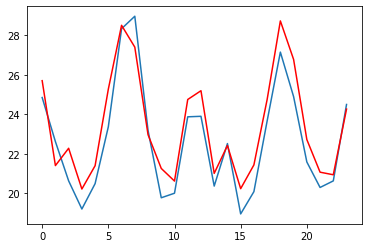

In [19]:
#plotting the model
plt.plot(yt)
plt.plot(reg_fit.predict(Xt), color = 'red')
#we seem to have a pretty decent model in terms of following the overall trend, but our predictions tend to be higher than the
#real values; let's look at the residuals of the model to see if we can  infer some other features

<AxesSubplot:>

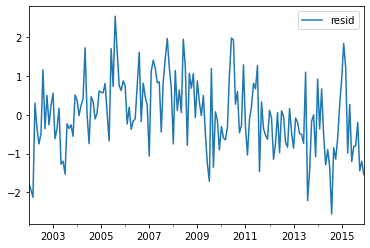

In [20]:
resid_df = pd.DataFrame({'resid':reg_fit.resid}, index = train.index)

resid_df.plot()

Starting from 2005, residuals seem to have a downwards trend. This means that our model is overestimating data from far in the past and underestimating recent data. This is consistent with our plotted predictions, which tend to be above the real time series line.

In [21]:
#looking at the residuals by month to see if there is any trend

resid_df['Month'] = resid_df.index.month
resid_df.groupby('Month').mean() #obviously, there's no significant monthly trend for the residuals as all values are 
#extremely low

,resid
Month,
1,7.105427e-15
2,1.344956e-14
3,1.116567e-14
4,1.319579e-14
5,8.881784e-15
6,7.866723e-15
7,2.537653e-16
8,4.821540e-15
9,7.612958e-15


In [22]:
resid_df['Year'] = resid_df.index.year
resid_df.groupby('Year').resid.mean() 

Year
2002   -0.489206
2003   -0.429131
2004    0.277819
2005    0.848847
2006    0.313867
2007    0.840442
2008    0.525168
2009   -0.246509
2010    0.371629
2011   -0.098127
2012   -0.381731
2013   -0.556480
2014   -0.645663
2015   -0.330924
Name: resid, dtype: float64

The table above confirms that there does seem to be some significant differences in the residuals by year. We can see what happens if we include year as a variable; in order to make differences in years meaningful, we'll take the number of years since 2000 as a predictor.

In [23]:
#adding new variable to the training set
train['Year'] = train.index.year
train['Y_2'] = train['Year'] - 2000
#same addition to the test set
test['Year'] = test.index.year
test['Y_2'] = test['Year'] - 2000


y2, X2 = patsy.dmatrices('PJME_TW ~ month_mean_pred + month_extreme_diff + Y_2', train)

reg2 = OLS(y2, X2)
reg2f = reg2.fit()

reg2f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                PJME_TW   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     398.5
Date:                Fri, 25 Sep 2020   Prob (F-statistic):           4.58e-75
Time:                        10:57:28   Log-Likelihood:                -224.98
No. Observations:                 168   AIC:                             458.0
Df Residuals:                     164   BIC:                             470.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3894      0.718      0.542      0.588      -1.028       1.807
month_mean_pred        1.0000      0.030     33.748      0.000       0.941       1.059
month_extreme_diff     0.0102      0.001      7.278      0.000       0.007       0.013
Y_2                   -0.0458      0.018     -2.552      0.012      -0.081      -0.010
==============================================================================
Omnibus:                        0.050   Durbin-Watson:                   1.255
Prob(Omnibus):                  0.976   Jarque-Bera (JB):                0.045
Skew:                           0.033   Prob(JB):                        0.978
Kurtosis:                       2.954   Cond. No.                         515.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that our model has incorporated a small, but nevertheless statistically significant, coefficient for year with a negative sign, indicating that when month and temperature are equal, there's a small decrease in expected electricity consumption year after year.

In [24]:
y2t, X2t = patsy.dmatrices('PJME_TW ~ month_mean_pred + month_extreme_diff + Y_2', test)
print_metrics(y2t, reg2f.predict(X2t))

The root mean squared error of the estimator is 0.95
The mean absolute percentage error of the estimator is 3.6 percent


We can see that our predictions get better as they incorporate year: a reduction of root mean squared error from 1.14 to 
0.95, and of mean absolute percentage error from 4.4 to 3.6 %, are significant improvements, especially as we are talking about TeraWatts.

Obviously, the most important component of the model is still the monthly mean, but taking into account temperature extremes means that the year needs to be taken into account also, with a significantly negative coefficient. 
This indicates that when month and temperature are equal, there's a small decrease in expected electricity consumption year after year, which might be the result of slight improvements in energy efficiency in air conditioners or home insulation.

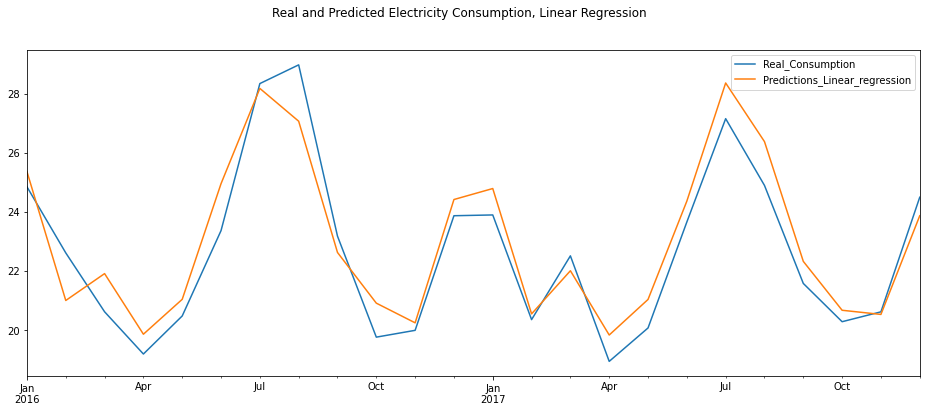

In [25]:
#plotting the model
lin_pred_df = pd.DataFrame({'Real_Consumption': test['PJME_TW'], 'Predictions_Linear_regression':reg2f.predict(X2t)})

fig = lin_pred_df.plot(figsize=(16,6)).get_figure()
fig.suptitle('Real and Predicted Electricity Consumption, Linear Regression')
fig.savefig('lin_preds2.png')

## What improvements can we get with ARIMA type terms?

We will now try to fit an ARIMA model, with the temperature extreme index (or rather, its deviation from its expected value for the month) as an exogenous variable.
In order to do this, we must first do the statistical tests and transformations to get a stationary series and determine the right parameters for the model.

### ARIMA without exogenous component

We start by making an ARIMA model without the exogenous component to determine which coeficients to put inside the model.

In [26]:
adfuller(train['PJME_TW'])

(-2.2595426052662444,
 0.1853483317019199,
 14,
 153,
 {'1%': -3.473829775724492,
  '5%': -2.880622899711496,
  '10%': -2.5769448985432954},
 507.8408013409426)

The series, to start with, is not stationary. To stationarize it, we can use the monthly mean electricity consupmtion to transform our data, which should remove most of the trend and make the series look more like stationary noise.

In [27]:
train['month_deviation'] = train['PJME_TW'] - train['month_mean_pred']
adfuller(train['month_deviation']) #the series that we get is stationary, we'll see whether we can predict it with ARIMA

(-8.131428481565594,
 1.0876111595055203e-12,
 0,
 167,
 {'1%': -3.470126426071447,
  '5%': -2.8790075987120027,
  '10%': -2.5760826967621644},
 432.4713430540029)

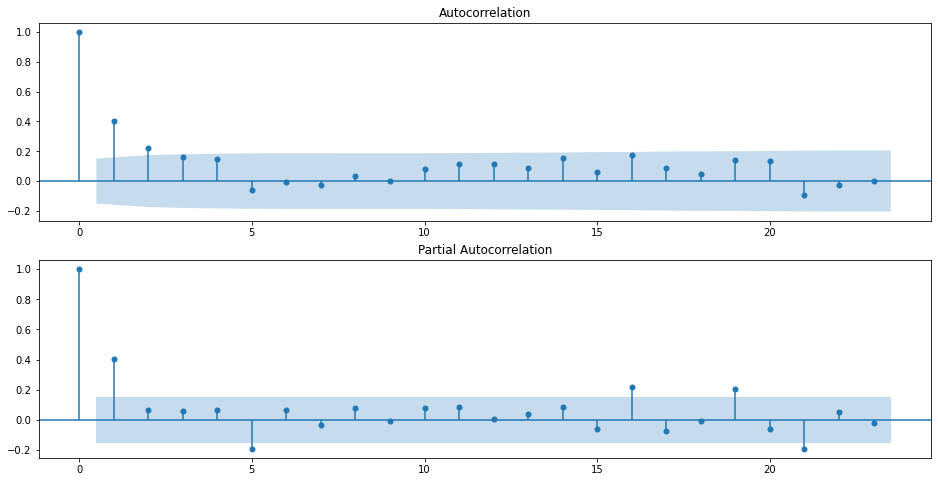

In [28]:
show_acf_plots(train['month_deviation']) 

We see that autocorrelation gradually decays, whereas partial autocorrelation drops sharply after lag 1; this is an AR signature, it indicates we should use the model ARIMA (1,0,0), at least to start.

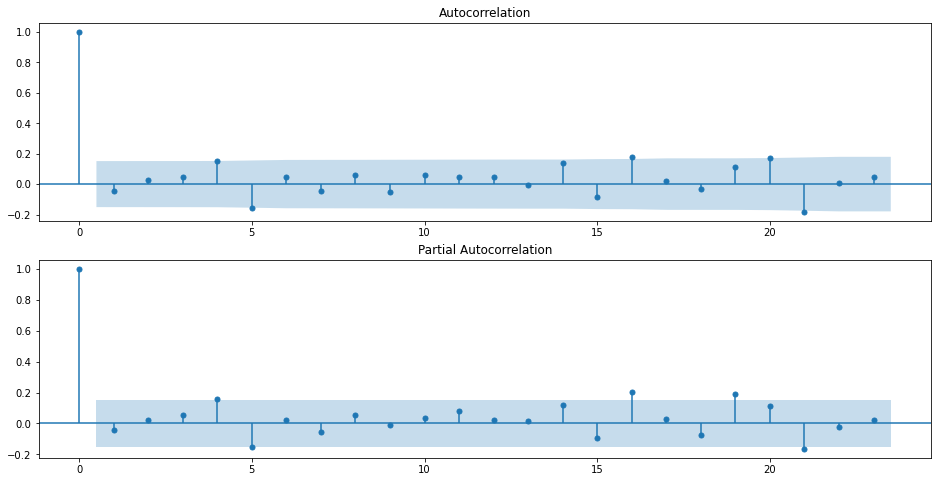

In [29]:
basic_model = ARIMA(train['month_deviation'], (1,0,0))

basic_model_fit = basic_model.fit()
show_acf_plots(basic_model_fit.resid)

In [30]:
basic_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        month_deviation   No. Observations:                  168
Model:                     ARMA(1, 0)   Log Likelihood                -233.670
Method:                       css-mle   S.D. of innovations              0.972
Date:                Fri, 25 Sep 2020   AIC                            473.339
Time:                        10:57:30   BIC                            482.711
Sample:                    01-31-2002   HQIC                           477.143
                         - 12-31-2015                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0251      0.132     -0.189      0.850      -0.285       0.234
ar.L1.month_deviation     0.4356      0.073      5.997      0.000       0.293       0.578
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2959           +0.0000j            2.2959            0.0000
-----------------------------------------------------------------------------
"""

In [31]:
raw_forecasts = basic_model_fit.forecast(steps = 24)[0]
test['raw_forecasts'] = raw_forecasts
test['adj_arima_forecasts'] = test['month_mean_pred'] + test['raw_forecasts']

print_metrics(test['PJME_TW'], test['adj_arima_forecasts'])

The root mean squared error of the estimator is 1.23
The mean absolute percentage error of the estimator is 4.6 percent


We can see that the root mean squared error of an AR model is a small improvement on the root mean squared error of just predicting the monthly means, which was 1.28, and that MAPE also decreases from 4.8 to 4.6%. Now let's see what happens if we add the same exogenous variables as we used for the linear model.

### Arima with eXogenous predictors

In [32]:
exog_model2 = SARIMAX(endog = train['month_deviation'], exog = train[['month_extreme_diff','Y_2']], order = (1,0,0))

exog_model2_fit = exog_model2.fit()
y_armax_preds = exog_model2_fit.forecast(steps=24, exog = test[['month_extreme_diff','Y_2']])[0]

test['y_armax_preds'] = y_armax_preds
test['alt_armax_preds'] = test['y_armax_preds'] + test['month_mean_pred']
print_metrics(test['alt_armax_preds'], test['PJME_TW'])

The root mean squared error of the estimator is 0.93
The mean absolute percentage error of the estimator is 3.1 percent


The RMSE that we get is slightly better than the one we got from simple linear regression with year as a predictor. Interestingly, the improvement of mean absolute percentage error is much better. This would indicate that our ARIMA model was generally a lot better, but that it made one or several errors that were larger for certain points in time.  

**Let's plot the two together to see how they compare**

<AxesSubplot:>

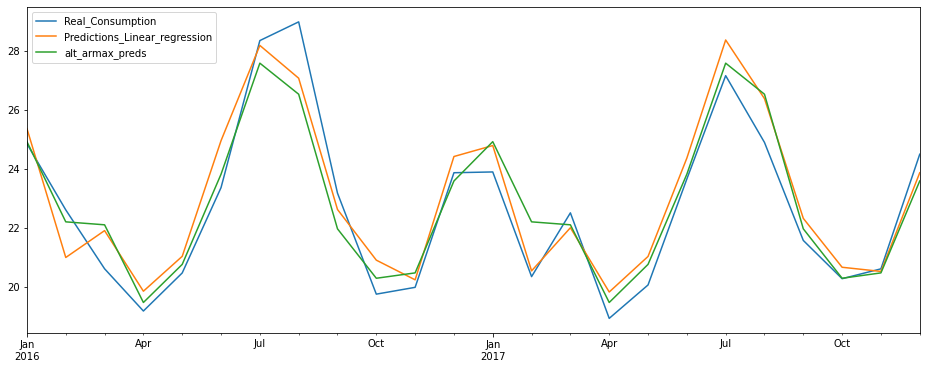

In [33]:
lin_pred_df['alt_armax_preds'] = test['alt_armax_preds']

lin_pred_df.plot(figsize=(16,6))

We can see that both models make predictions that are quite close to each other, and that generally capture the trend of the reality quite well. For most of the period, the predictions of the ARIMA model, the green line, are closer to reality than the predictions of the linear regression model, the blue line. However, the predictions of the linear regression model become better in the period between July and September 2016. The ARIMA model generally seems to be less sensitive to the temperature extreme variable. 

The choice of model to put in production would depend on the metric we are most interested in: if we care more about RMSE, then linear regression is a good choice as it is easier to interpret and gets results that are almost as good. If we care more about MAPE, then ARIMA with exogenous variables generally makes better predictions.

Next, we will try xgboost to see if it can produce better predictions.

## Predictions with XGBoost

XGBoost is a tree based algorithm, therefore we can use the month number as a predictive variable as well as the year, as XGBoost can pick up non linear relationships and interactions related to the month. 

While the month is, in a sense, 'mean encoded' inside the month_mean_pred variable, keeping it as a raw feature also could be useful in an algorithm like XGBoost, as there may be some trends and interactions that happen only in the beginning of the year, or only in specific months.

In [34]:
X = train.loc[:, ['Value', 'month_mean_pred','Temp_extreme_index', 'Month', 'month_extreme_diff', 'Year']]
y = train.loc[:, 'PJME_TW']
Xt = test.loc[:, ['Value', 'month_mean_pred', 'Temp_extreme_index', 'Month', 'month_extreme_diff', 'Year']]
yt = test.loc[:, 'PJME_TW']

In [35]:
reg_XGB = xgb.XGBRegressor(objective='reg:squarederror')

In [36]:
reg_XGB.fit(X,y, eval_set=[(X, y), (Xt, yt)], early_stopping_rounds = 10, verbose=True)

[0]	validation_0-rmse:16.36725	validation_1-rmse:15.49316
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:11.56555	validation_1-rmse:10.69917
[2]	validation_0-rmse:8.19772	validation_1-rmse:7.34239
[3]	validation_0-rmse:5.83116	validation_1-rmse:4.96557
[4]	validation_0-rmse:4.17676	validation_1-rmse:3.35165
[5]	validation_0-rmse:3.02548	validation_1-rmse:2.20467
[6]	validation_0-rmse:2.22609	validation_1-rmse:1.59563
[7]	validation_0-rmse:1.66873	validation_1-rmse:1.28323
[8]	validation_0-rmse:1.27878	validation_1-rmse:1.06822
[9]	validation_0-rmse:0.99356	validation_1-rmse:0.89901
[10]	validation_0-rmse:0.79783	validation_1-rmse:0.85247
[11]	validation_0-rmse:0.65482	validation_1-rmse:0.81799
[12]	validation_0-rmse:0.56944	validation_1-rmse:0.82448
[13]	validation_0-rmse:0.48323	validation_1-rmse:0.86313
[14]	validation_0-rmse:0.43930	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
xgb_preds = reg_XGB.predict(Xt)

print_metrics(yt, xgb_preds)

The root mean squared error of the estimator is 0.82
The mean absolute percentage error of the estimator is 2.8 percent


By itself, an untuned XGBoost model already does significantly better than ARIMA with exogenous parameters or a simple linear model.

### XGBoost Parameter Tuning

Let's see if we can get even more improvement by tuning the hyper-parameters.
For XGBoost, since the algorithm gives us its scores on the validation set right away, and since there are far too many parameters that can be tuned to put in a grid search in a reasonable time frame, we will tune the parameters 'manually', one by one. For this  we use a custom built tracker, like in the previous XGBoost notebook.


In [38]:
reg_XGB2 = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = .1, random_state = 27314)

In [39]:
my_tracker = param_tracker(reg_XGB2, X, y, Xt, yt)
my_tracker.test_params('max_depth', range(2,8))

results for max_depth of 2: rmse 0.79768
updated parameters: new best score = 0.79768
results for max_depth of 3: rmse 0.703771
updated parameters: new best score = 0.703771
results for max_depth of 4: rmse 0.725783
results for max_depth of 5: rmse 0.75254
results for max_depth of 6: rmse 0.720082
results for max_depth of 7: rmse 0.804896


We continue with a max depth of 3.

In [40]:
my_tracker.test_params('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1])

results for colsample_bytree of 0.5: rmse 0.769833
results for colsample_bytree of 0.6: rmse 0.769833
results for colsample_bytree of 0.7: rmse 0.766076
results for colsample_bytree of 0.8: rmse 0.766076
results for colsample_bytree of 0.9: rmse 0.767044
results for colsample_bytree of 1: rmse 0.703771


Using only a portion of columns in each tree does not improve results. We continue with every column.

In [41]:
my_tracker.test_params('subsample', [.7, .8, .85, .9, .95, 1])

results for subsample of 0.7: rmse 0.739761
results for subsample of 0.8: rmse 0.792304
results for subsample of 0.85: rmse 0.799561
results for subsample of 0.9: rmse 0.701267
updated parameters: new best score = 0.701267
results for subsample of 0.95: rmse 0.73074
results for subsample of 1: rmse 0.703771


Using a subsample of data of 0.9 gives us the best results.

Now we move on to regularization, with gamma and reg_lambda parameters.

In [42]:
my_tracker.test_params('gamma', [0, 0.1, 0.3, 0.5, 1, 2, 5])

results for gamma of 0: rmse 0.701267
results for gamma of 0.1: rmse 0.701042
updated parameters: new best score = 0.701042
results for gamma of 0.3: rmse 0.734169
results for gamma of 0.5: rmse 0.730065
results for gamma of 1: rmse 0.741619
results for gamma of 2: rmse 0.753081
results for gamma of 5: rmse 0.798551


A gamma value of 0.1 led to a tiny improvement in the model. This is a really small value for gamma, so it probably pruned a single branch that was built with a very tiny gain.

In [43]:
my_tracker.test_params('reg_lambda', [0, 0.5, 1, 1.5, 2, 4, 8])

results for reg_lambda of 0: rmse 0.681792
updated parameters: new best score = 0.681792
results for reg_lambda of 0.5: rmse 0.708584
results for reg_lambda of 1: rmse 0.701042
results for reg_lambda of 1.5: rmse 0.772787
results for reg_lambda of 2: rmse 0.758316
results for reg_lambda of 4: rmse 0.792025
results for reg_lambda of 8: rmse 0.796226


Reducing the value of lambda to 0 from its default value of 1 has led to an improvement in the model. This increases the sensitivity of the  model to individual observations, but the improvement looks notable enough to keep.

In [44]:
ftuned_xgb = xgb.XGBRegressor(**my_tracker.params)
ftuned_xgb.fit(X, y, eval_set=[(X, y), (Xt, yt)], early_stopping_rounds = 10, verbose=True)

[0]	validation_0-rmse:20.88771	validation_1-rmse:20.00461
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:18.80764	validation_1-rmse:17.91013
[2]	validation_0-rmse:16.92863	validation_1-rmse:16.01421
[3]	validation_0-rmse:15.23910	validation_1-rmse:14.32107
[4]	validation_0-rmse:13.72478	validation_1-rmse:12.82831
[5]	validation_0-rmse:12.35768	validation_1-rmse:11.45931
[6]	validation_0-rmse:11.12814	validation_1-rmse:10.23645
[7]	validation_0-rmse:10.02306	validation_1-rmse:9.15094
[8]	validation_0-rmse:9.03188	validation_1-rmse:8.19420
[9]	validation_0-rmse:8.13485	validation_1-rmse:7.33587
[10]	validation_0-rmse:7.33255	validation_1-rmse:6.55718
[11]	validation_0-rmse:6.60820	validation_1-rmse:5.88236
[12]	validation_0-rmse:5.95442	validation_1-rmse:5.25370
[13]	validation_0-rmse:5.37045	validation_1-rmse:4.66903
[14]	validation_0-rmse:4.84538	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             random_state=27314, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=0.9, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [45]:
ftuned_xgb_preds = ftuned_xgb.predict(Xt)

print_metrics(yt, ftuned_xgb_preds)

The root mean squared error of the estimator is 0.68
The mean absolute percentage error of the estimator is 2.3 percent


Parameter tuning led to a further reduction of the root mean squared error by approximately .13, this is similar to the improvement that we obtained from going from an ARIMAX model to un-tuned XGBoost. MAPE has also decreased to only 2.3 %.

### Visualizing the xgboost predictions and the real electricity consumption

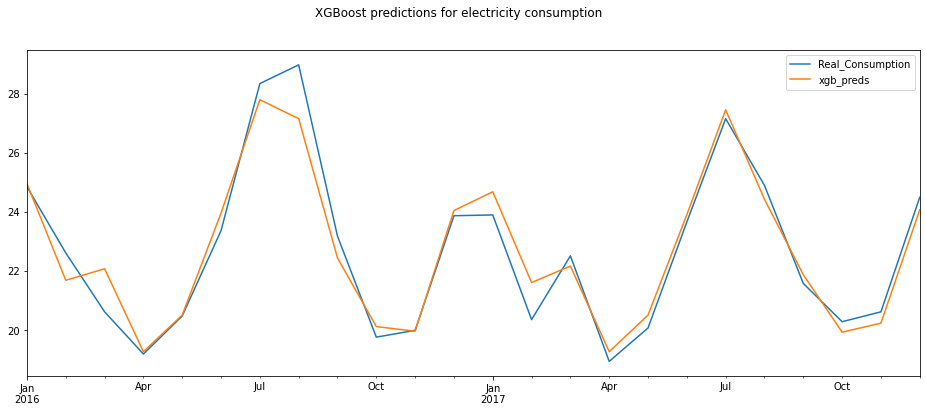

In [46]:
lin_pred_df['xgb_preds'] = ftuned_xgb_preds
fig = lin_pred_df[['Real_Consumption', 'xgb_preds']].plot(figsize = (16,6)).get_figure()
fig.suptitle('XGBoost predictions for electricity consumption')
fig.savefig('XGBoost predictions.png')

We can see that our predictions are generally very close to the reality, except for July and August 2016, and Dec 2016-February 2017. These could be periods for which the weather that was observed in the region diverged from the national weather averages.

## Feature importances of the XGBoost model

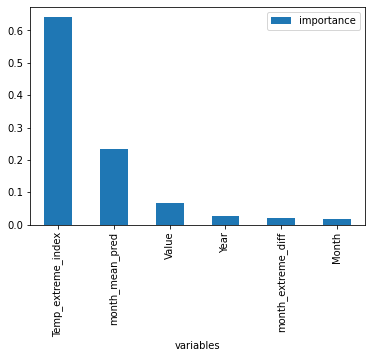

In [47]:
plot_feature_importances(ftuned_xgb, X)

We can see that the temperature index played the largest role by far in the XGBoost model.

## Visualizing all of the predictions together

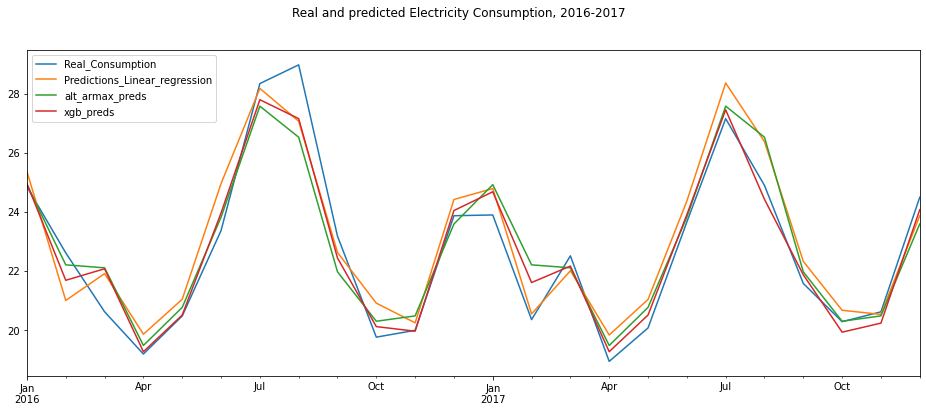

In [48]:
fig = lin_pred_df.plot(figsize=(16,6)).get_figure()
fig.suptitle('Real and predicted Electricity Consumption, 2016-2017')
fig.savefig('final_weather_pred_graph.png')

Interestingly, all of our models are making errors at the same periods. This means that the most likely issue is with our data, or with our features, rather than with the models themselves. 

The most likely explanation for the big error in August 2016 is the fact that temperatures in the PJME region were exceptionally high, but national temperatures, for which we have the data, were less extreme, as can be seen on these maps:

<img src='images/US_temp_ranks_August16.png' />

## Summary of metrics for all models

In [49]:
models = list(lin_pred_df.columns)[1:]
metrics_summary = pd.DataFrame({'model':models, 
                                'rmse': [np.round(rmse(lin_pred_df['Real_Consumption'], lin_pred_df[model]),2) for model in models], 
                                'mape': [np.round(mape(lin_pred_df['Real_Consumption'], lin_pred_df[model]), 2) for model in models]})
metrics_summary.set_index('model', inplace = True)

metrics_summary.to_html('metrics_summary.html')

metrics_summary

,rmse,mape
model,,
Predictions_Linear_regression,0.95,3.58
alt_armax_preds,0.93,3.11
xgb_preds,0.68,2.29
